In [78]:
import sys, os
sys.path.insert(0, os.path.abspath('/home/tguethle/Documents/spi/Master_Thesis/main_files'))


import numpy as np
import scipy as sp
import astropy.io.fits as fits
from astropy.table import Table
from astromodels import Powerlaw, PointSource, SpectralComponent
import astropy.time as at
from datetime import datetime
from pyspi.utils.function_utils import find_response_version
from pyspi.utils.response.spi_response_data import ResponseDataRMF
from pyspi.utils.response.spi_response import ResponseRMFGenerator
from pyspi.utils.response.spi_drm import SPIDRM
from pyspi.utils.livedets import get_live_dets
import os
from MultinestClusterFit import powerlaw_binned_spectrum, MultinestClusterFit
from RebinningFunctions import spimodfit_binning_SE, log_binning_function_for_x_number_of_bins, no_rebinning #, rebin_data_exp_50
from PointingClusters import PointingClusters, save_clusters, load_clusters
from ModelSources import *
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib

In [80]:
fit_vals_beuermann_same_E = [
    2.291328564907838959e-04,
    -1.934083387329433190e+00,
    -2.639646846040984762e+00,
    1.654420241902389677e+00,
    2.004543003628248243e+02,
]

n1 = fit_vals_beuermann_same_E[1] * fit_vals_beuermann_same_E[3]
n2 = fit_vals_beuermann_same_E[2] * fit_vals_beuermann_same_E[3]
E = fit_vals_beuermann_same_E[4]

def func(x, n1, n2, E):
    return (x/E)**n1 + (x/E)**n2 - 1

res = sp.optimize.fsolve(func, 1, args=())

res

array([61.80339887])

Compare the generated counts of pyspi with the output file from Spimodfit. Apperantly the convsky_output file contains these expacted counts

## Spimodfit output

parameters for this spimodfit run 
index = -2
K = 7e-2
piv = 100

In [72]:
# take a look at the response of spimodfit
spimodfit_path_1160 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
spimodfit_path_41 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_374_center_test/"

response_name = "convolved_sky_images.fits"

with fits.open(spimodfit_path_41 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)
counts_41 = t["COUNTS"]
err_41 = np.array(t["STAT_ERR"])

with fits.open(spimodfit_path_1160 + response_name) as hdul:
    t = Table(hdul[2].data)
    header = hdul[2].header
    t2 = Table(hdul[1].data)


counts_1160 = t["COUNTS"]
err_1160 = np.array(t["STAT_ERR"])

spimodfit_counts_41, spimodfit_counts_1160 = np.array(counts_41), np.array(counts_1160)



In [73]:
# take a look at the response of spimodfit
spimodfit_path_1160 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_bright_100_small_bins/"
spimodfit_path_41 = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/fit_Crab_normal_new/"

spiselect_path = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/dataset_normal_new/spi/"

response_name = "convolved_sky_images.fits"
orig_data_path = "/home/tguethle/cookbook/SPI_cookbook/examples/automated_Crab/dataset_normal_new/spi/"

# Energy Bins
with fits.open(f"{orig_data_path}/energy_boundaries.fits.gz") as file:

    t = Table.read(file[1])
    energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
    print(f'Number of energy bins: {len(energy_bins)-1}')
# Pointings and Start Times
with fits.open(f"{orig_data_path}/pointing.fits.gz") as file:
    t = Table.read(file[1])
    
    pointings = np.array(t["PTID_SPI"])
    
    time_start = np.array(t["TSTART"]) + 2451544.5
    time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
    time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


# Time Elapsed
# det=i, pointing_index=j : index = j*85 + i
with fits.open(f"{orig_data_path}/dead_time.fits.gz") as file:
    
    t = Table.read(file[1])
    time_elapsed = np.array(t["LIVETIME"])

with fits.open(spimodfit_path_41 + response_name) as hdul:
    t2 = Table(hdul[2].data)
    header = hdul[2].header
    t22 = Table(hdul[1].data)
counts_41 = t2["COUNTS"]
err_41_low_K = np.array(t2["STAT_ERR"])



spimodfit_counts_41_low_K = np.array(counts_41)

Number of energy bins: 41


In [74]:
e_bounds_width = np.array(energy_bins[1:]) - np.array(energy_bins[:-1])
e_bounds_width

array([ 1.5,  2. ,  2. ,  2. ,  2.5,  2.5,  3. ,  3. ,  3.5,  3.5,  4. ,
        4.5,  4.5,  5. ,  5.5,  6. ,  6.5,  7.5,  7.5,  8.5,  9. , 10. ,
       10.5, 11.5, 13. , 13.5, 15. , 16.5, 17.5, 19. , 21. , 22.5, 24.5,
       27. , 29. , 31.5, 34. , 37.5, 40.5,  6. , 86. ], dtype=float32)

(19, 41)


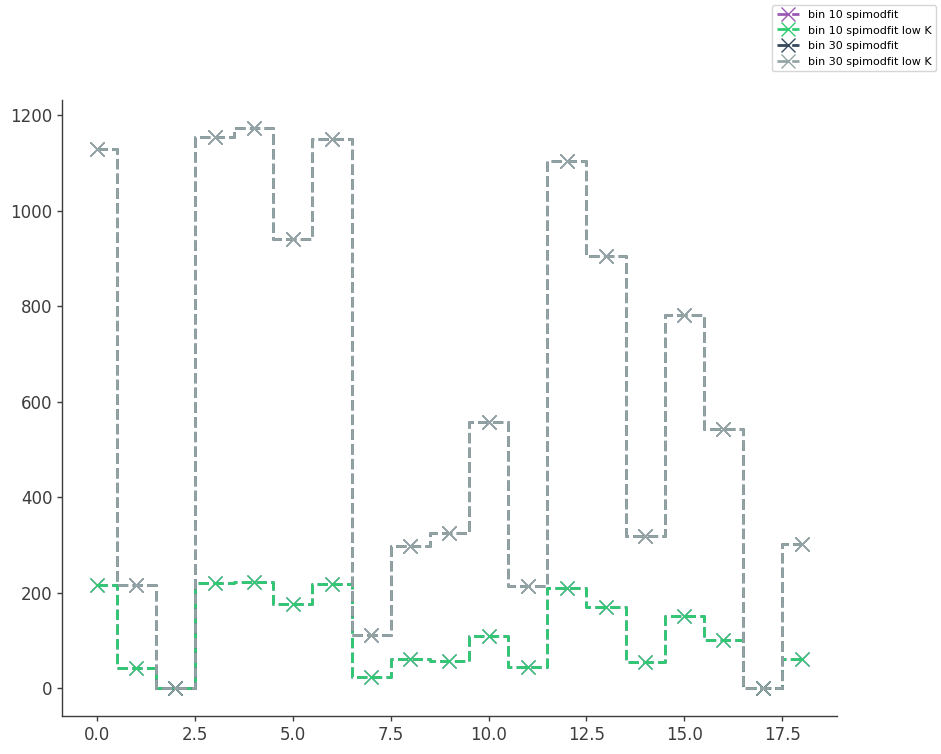

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
dets = np.arange(0, 19, 1)
bins = (0,10,20,30,40)
bins = (10,30)

pointing_id = (0,)

smf_high_K, = [spimodfit_counts_41[(id * 19):(id +1) * 19] for id in pointing_id]
smf_low_K, = [spimodfit_counts_41_low_K[(id * 19):(id +1) * 19] for id in pointing_id]

print(smf_high_K.shape)

for b in bins:
    ax.step(dets, smf_high_K[:,b], label=f"bin {b} spimodfit", linestyle="--", marker="x", where="mid", markersize=10)

    ax.step(dets, smf_low_K[:,b], label=f"bin {b} spimodfit low K", linestyle="--", marker="x", where="mid", markersize=10)

fig.legend()

*Plot spectrum*

In [65]:
source_counts = np.zeros((len(pointings)*85, len(energy_bins)-1), dtype=np.uint32)
bins_mid = (energy_bins[1:] + energy_bins[:-1])/2
dets = np.arange(0, 19, 1)


def powerlaw(x, K=7e-4,index=-2,piv=100):
    return K * (x/piv)**index

for i, p_i in enumerate(pointings):
    for j, det in enumerate(dets):
        source_counts[i*85 + j] = np.random.poisson(powerlaw(bins_mid, K=7e-5, index=-2, piv=100) * time_elapsed[i*19 + j] * spimodfit_counts_41_low_K[i*19 + j])

In [66]:
powerlaw(bins_mid, K=7e-2, index=-2, piv=100)

array([1.6257803 , 1.3827162 , 1.1661807 , 0.99679613, 0.8468809 ,
       0.7168    , 0.6055363 , 0.51132214, 0.4320821 , 0.36571428,
       0.31024933, 0.26138303, 0.22123457, 0.18812147, 0.15948735,
       0.13503085, 0.11432187, 0.09631839, 0.08137111, 0.06896169,
       0.05838076, 0.04943154, 0.04190221, 0.03558708, 0.03009944,
       0.0254795 , 0.02160494, 0.01826815, 0.01546532, 0.0131182 ,
       0.01111094, 0.00940954, 0.00797593, 0.00675128, 0.00571429,
       0.00484127, 0.00410391, 0.00347607, 0.00294241, 0.00268075,
       0.00225625], dtype=float32)

In [67]:
with fits.open("/home/tguethle/Documents/spi/Master_Thesis/main_files/smf_simulations/test_data_normal_new_small_K/evts_det_spec.fits") as file:
    t = Table.read(file[1])
    source_bkg_counts = np.array(t["COUNTS"])
source_counts.shape

(3485, 41)

In [68]:
with fits.open("/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center/evts_det_spec.fits") as file:
    t = Table.read(file[1])
    bkg_counts = np.array(t["COUNTS"])

In [69]:
assert source_counts.all() == source_bkg_counts.all()


In [70]:
print(source_counts[85:85+19, 10])
print(source_bkg_counts[85:85+19,10])
print(bkg_counts[85:85+19,10])

[713 287   0 699 693 439 782 156 196  61 348 261 689 375  60 580 342   0
 216]
[1455 1032    0 1482 1274 1212 1341  852  972  835 1134 1040 1527 1054
  769 1244 1027    0 1020]
[777 720   0 741 668 761 663 682 764 773 765 758 809 687 704 677 690   0
 795]


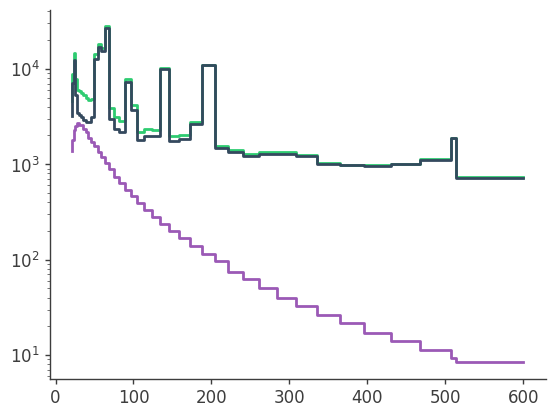

In [71]:
smf_spectrum = spimodfit_counts_41_low_K.sum(axis=0), smf_high_K.sum(axis=0)

plt.yscale("log")
# plt.step(energy_bins[1:], smf_spectrum[0] / e_bounds_width, label="spimodfit low K")
plt.step(energy_bins[1:], source_counts[85:85+19].sum(axis=0) / e_bounds_width, label="spimodfit low K")
plt.step(energy_bins[1:], source_bkg_counts[85:85+19].sum(axis=0) / e_bounds_width, label="spimodfit low K")
plt.step(energy_bins[1:], bkg_counts[85:85+19].sum(axis=0) / e_bounds_width, label="spimodfit low K")
# plt.plot(smf_spectrum[1], label="spimodfit low K")


plot the counts for different detectors of one pointing. For now plot with only one energy bin

## Pyspi

In [ ]:
# defining the source
K = 7e-2
ra, dec = 10, -40
index_pl = -2
piv = 100
# ra, dec = 155., 75.
# K, piv, index = 3e-3, 40, -1
data_path = '/home/tguethle/Documents/spi/Master_Thesis/main_files/sim_source_real_bkg/bright_100_new/0374'
orig_data_path_1160 = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center_small_bins'
orig_data_path_41 = '/home/tguethle/Documents/spi/Master_Thesis/spiselect_SPI_Data/0374_center'
# Define  Spectrum
def create_counts(orig_data_path, K=7e-2):
    print(f"Using k = {K}")
    pl = Powerlaw()
    pl.piv = piv
    pl.K = K
    pl.index = index_pl
    component1 = SpectralComponent("pl", shape=pl)
    source = PointSource("Test", ra=ra, dec=dec, components=[component1])

    #emod = np.geomspace(18, 2000, 200)
    emod = np.arange(20, 600.5, 0.5)
    spec = source(emod)
    spec_binned = powerlaw_binned_spectrum(emod, spec)


    # Energy Bins
    with fits.open(f"{orig_data_path}/energy_boundaries.fits") as file:

        t = Table.read(file[1])
        energy_bins = np.append(t["E_MIN"], t["E_MAX"][-1])
        print(f'Number of energy bins: {len(energy_bins)-1}')
    # Pointings and Start Times
    with fits.open(f"{orig_data_path}/pointing.fits") as file:
        t = Table.read(file[1])
        
        pointings = np.array(t["PTID_SPI"])
        
        time_start = np.array(t["TSTART"]) + 2451544.5
        time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
        time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])


    # Time Elapsed
    # det=i, pointing_index=j : index = j*85 + i
    with fits.open(f"{orig_data_path}/dead_time.fits") as file:
        
        t = Table.read(file[1])
        time_elapsed = np.array(t["LIVETIME"])

    # Generate Source Counts

    assert find_response_version(time_start[0]) == find_response_version(time_start[-1]), "Versions not constant"
    version = find_response_version(time_start[0])
    rsp_base = ResponseDataRMF.from_version(version)

    source_counts = np.zeros((len(pointings)*85, len(energy_bins)-1), dtype=np.uint32)
    np_source_counts = np.zeros((len(pointings)*19, len(energy_bins)-1), dtype=np.uint32)

    for p_i, pointing in enumerate(pointings):
        
        time = time_start[p_i]
        dets = get_live_dets(time=time, event_types=["single"])
        
        rmfs = []
        for d in dets:
            rmfs.append(ResponseRMFGenerator.from_time(time, d, energy_bins, emod, rsp_base))
            
        sds = np.empty(0)
        for d in range(len(dets)):
            sd = SPIDRM(rmfs[d], ra, dec)
            sds = np.append(sds, sd.matrix.T)
        resp_mat = sds.reshape((len(dets), len(emod)-1, len(energy_bins)-1))
        
        count_rates = np.dot(spec_binned, resp_mat)
        
        for d_i, d in enumerate(dets):
            index = p_i * 85 + d
            counts_index = p_i * 19 + d
            source_counts[index,:] = np.random.poisson(count_rates[d_i,:] * time_elapsed[index])
            np_source_counts[counts_index,:] = count_rates[d_i,:] * time_elapsed[index]

    with fits.open(f"{orig_data_path}/evts_det_spec_orig.fits") as file:
        t = Table.read(file[1])
        
        counts = t
        

    total_counts = counts["COUNTS"] + source_counts

    return source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat


In [ ]:
# source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = create_counts(orig_data_path_41)

In [ ]:
res_41 = create_counts(orig_data_path_41)

res_41_low_K = create_counts(orig_data_path_41, K=7e-4)
# res_1160 = create_counts(orig_data_path_1160)

In [ ]:
bin_widths = energy_bins[1:] - energy_bins[:-1]
bin_widths

In [ ]:
pyspi_counts_41 = np.array(res_41[0], dtype=np.float64)
pyspi_counts_41_low_K = np.array(res_41_low_K[0], dtype=np.float64)

# np.save("pyspi_counts_41.npy", pyspi_counts_41)
# np.save("pyspi_counts_41_low_K.npy", pyspi_counts_41_low_K)

In [6]:
pyspi_counts_41 = np.load("pyspi_counts_41.npy")
pyspi_counts_41_low_K = np.load("pyspi_counts_41_low_K.npy")


In [11]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

def divide_by_mean(arr):
    mean = np.nanmean(arr, axis=0)
    return arr / mean

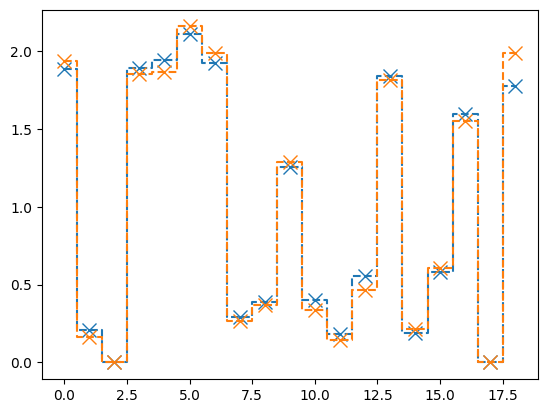

In [15]:
%matplotlib inline
pointing_id = (10,15)

pyspi_detector_counts, pyspi_detector_counts_2 = [pyspi_counts_41[(id * 85):(id * 85) + 19] for id in pointing_id]
pyspi_detector_counts_low_K, pyspi_detector_counts_2_low_K = [pyspi_counts_41_low_K[(id * 85):(id * 85) + 19] for id in pointing_id]

plt.step(dets, divide_by_mean(pyspi_detector_counts)[:,10], label="pyspi", linestyle="--", marker="x", where="mid", markersize=10)
plt.step(dets, divide_by_mean(pyspi_detector_counts_low_K)[:,10], label="pyspi low K", linestyle="--", marker="x", where="mid", markersize=10)


In [ ]:
%matplotlib inline

pointing_id = (0,15)

# load data for high K
smf_detector_counts, smf_detector_counts_2 = [spimodfit_counts_41[(id * 19):(id +1) * 19] for id in pointing_id]
pyspi_detector_counts, pyspi_detector_counts_2 = [pyspi_counts_41[(id * 85):(id * 85) + 19] for id in pointing_id]

e1, e2 =  [err_41[(id * 19):(id +1) * 19] for id in pointing_id]
e1, e2 = e1 / np.nanmean(smf_detector_counts, axis=0), e2 / np.nanmean(smf_detector_counts_2, axis=0)


smf_detector_counts, smf_detector_counts_2 = divide_by_mean(smf_detector_counts), divide_by_mean(smf_detector_counts_2)
pyspi_detector_counts, pyspi_detector_counts_2 = divide_by_mean(pyspi_detector_counts), divide_by_mean(pyspi_detector_counts_2)

# load data for low K
smf_detector_counts_low_K, smf_detector_counts_2_low_K = [spimodfit_counts_41_low_K[(id * 19):(id +1) * 19] for id in pointing_id]
pyspi_detector_counts_low_K, pyspi_detector_counts_2_low_K = [pyspi_counts_41_low_K[(id * 85):(id * 85) + 19] for id in pointing_id]

e1_low_K, e2_low_K =  [err_41_low_K[(id * 19):(id +1) * 19] for id in pointing_id]
e1_low_K, e2_low_K = e1_low_K / np.nanmean(smf_detector_counts_low_K, axis=0), e2_low_K / np.nanmean(smf_detector_counts_2_low_K, axis=0)

smf_detector_counts_low_K, smf_detector_counts_2_low_K = divide_by_mean(smf_detector_counts_low_K), divide_by_mean(smf_detector_counts_2_low_K)
pyspi_detector_counts_low_K, pyspi_detector_counts_2_low_K = divide_by_mean(pyspi_detector_counts_low_K), divide_by_mean(pyspi_detector_counts_2_low_K)


# somehow deal with the errors


dets = np.arange(19)

c = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18"]

print(np.where(pyspi_detector_counts_low_K == 0))

fig, ((ax, ax2), (ax12, ax22)) = plt.subplots(2, 2, figsize=(20, 16))
# ax.plot(dets, smf_detector_counts[:,0], label="bin 0", c=c[0], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,5], label="bin 5", c=c[1], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,20], label="bin 20", c=c[2], linestyle="-")
# ax.plot(dets, smf_detector_counts[:,35], label="bin 35", c=c[3], linestyle="-")

for a in (ax, ax2, ax12, ax22):
    a.set_xticks(dets)

    a.grid(axis="x")
    a.set_xlabel("Detector")

ax.set_title(f"High Flux, K=7e-2 - pointing {pointing_id[0]}")
ax2.set_title(f"High Flux, K=7e-2 - pointing {pointing_id[1]}")
ax12.set_title(f"Low Flux, K=7e-4 - pointing {pointing_id[0]}")
ax22.set_title(f"Low Flux, K=7e-4 - pointing {pointing_id[1]}")

for bin, color in zip((20,), c):
    ax.step(dets, pyspi_detector_counts[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax.step(dets, smf_detector_counts[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)

    # show spimodfit errors
    ax.fill_between(dets, smf_detector_counts[:,bin] - e1[:,bin], smf_detector_counts[:,bin] + e1[:,bin], color=color, alpha=0.3, step="mid")
    ax12.fill_between(dets, smf_detector_counts_low_K[:,bin] - e1_low_K[:,bin], smf_detector_counts_low_K[:,bin] + e1_low_K[:,bin], color=color, alpha=0.3, step="mid")


    ax12.step(dets, pyspi_detector_counts_low_K[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax12.step(dets, smf_detector_counts_low_K[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)


for bin, color in zip((10,20,40), c):
    ax2.step(dets, pyspi_detector_counts_2[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax2.step(dets, smf_detector_counts_2[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)
    ax22.step(dets, pyspi_detector_counts_2_low_K[:,bin], c=color, label=f"bin {bin} pyspi", linestyle="-", where="mid")
    ax22.step(dets, smf_detector_counts_2_low_K[:,bin], label=f"bin {bin} spimodfit", c=color, linestyle="--", marker="x", where="mid", markersize=10)


# ax.plot(dets, pyspi_detector_counts[:,0], label="bin 0", c=c[0], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,5], label="bin 5", c=c[1], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,20], label="bin 20", c=c[2], linestyle="--")
# ax.plot(dets, pyspi_detector_counts[:,35], label="bin 35", c=c[3], linestyle="--")


fig.legend()



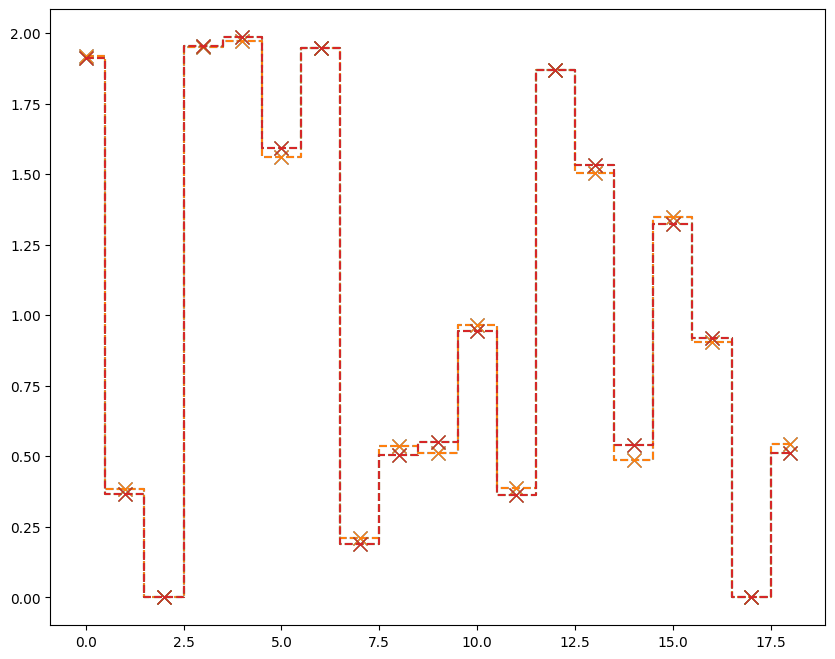

NameError: name 'res_41' is not defined

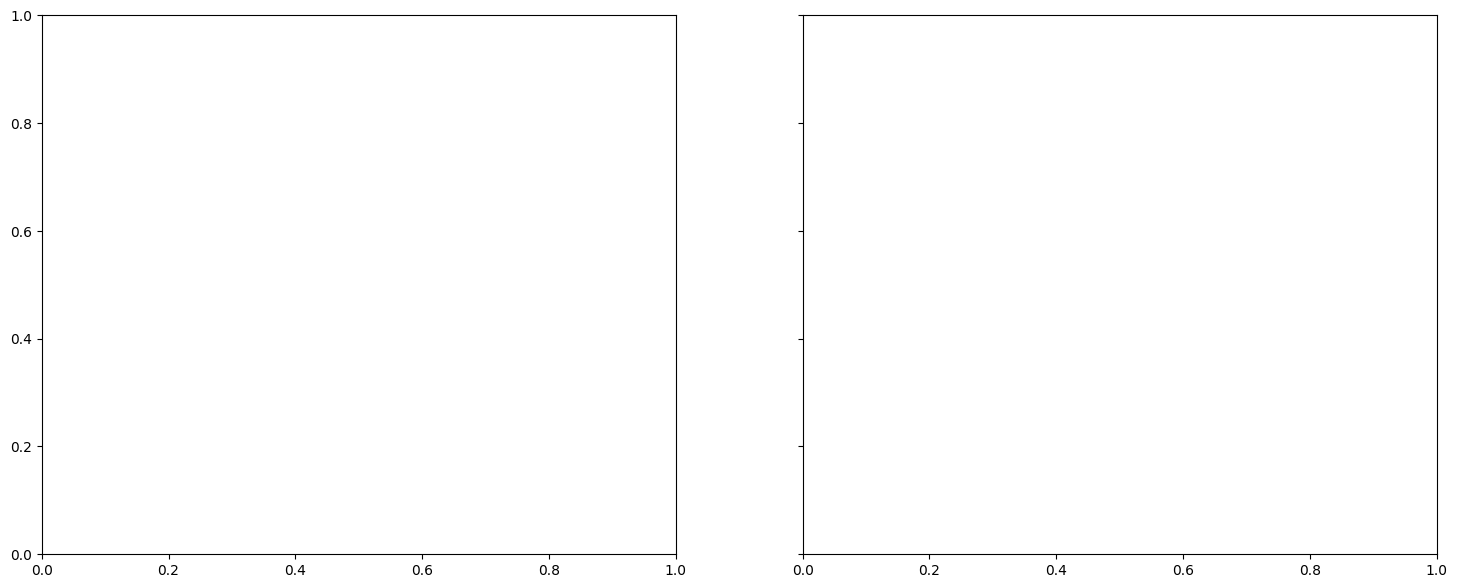

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for i, res, spimodfit_c in zip((0,1), (res_41, res_1160), (spimodfit_counts_41, spimodfit_counts_1160)):
    source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = res
    bin_widths = energy_bins[1:] - energy_bins[:-1]
    index = 0
    for index, line in zip([0, 10], ("solid", "dashed")):
        ax[i].step(energy_bins[1:], source_counts[index] / bin_widths, where='pre', label=f'Source Counts Det {index}', linestyle=line)
        ax[i].step(energy_bins[1:], total_counts[index] / bin_widths, where='pre', label=f'Total Counts Det {index}', linestyle=line)
        ax[i].step(energy_bins[1:], spimodfit_c[index] / bin_widths, where='pre', label=f'Spimodfit Counts Det {index}', linestyle=line)
        ax[i].set_title(f"Counts with {len(energy_bins)-1} energy bins")
    ax[i].set_yscale('log')
    ax[i].grid()
    
    ax[i].set_xlabel("Energy [keV]")
    ax[i].set_ylabel("Counts / keV")
    ax[i].legend()

# fig.savefig("Counts_comparison.pdf")

In [ ]:
# with errorbars
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

for i, res, spimodfit_c, spimodfit_err in zip((0,1), (res_41, res_1160), (spimodfit_counts_41, spimodfit_counts_1160), (err_41, err_1160)):
    source_counts, total_counts, np_source_counts, energy_bins, time_elapsed, resp_mat = res
    bin_widths = energy_bins[1:] - energy_bins[:-1]
    index = 0
    for index, line, show_err in zip([0, 10], ("solid", "dashed"), (True, True)):
        ax[i].step(energy_bins[1:], source_counts[index] / bin_widths, where='pre', label=f'Source Counts Det {index}', linestyle=line, color="C0")
        ax[i].step(energy_bins[1:], total_counts[index] / bin_widths, where='pre', label=f'Total Counts Det {index}', linestyle=line, color="C1")
        ax[i].step(energy_bins[1:], spimodfit_c[index] / bin_widths, where='pre', label=f'Spimodfit Counts Det {index}', linestyle=line, color="C2")
         # Fill the area between the spimodfit counts minus the error and the spimodfit counts plus the error
        if show_err:
            ax[i].fill_between(
                energy_bins[1:], 
                (spimodfit_c[index] / bin_widths) - spimodfit_err[index], 
                (spimodfit_c[index] / bin_widths) + spimodfit_err[index], 
                alpha=0.3, label="Spimodfit Error", color="C2"
            )
        ax[i].set_title(f"Counts with {len(energy_bins)-1} energy bins")
    ax[i].set_yscale('log')
    ax[i].grid()
    
    ax[i].set_xlabel("Energy [keV]")
    ax[i].set_ylabel("Counts / keV")
    ax[i].legend()

fig.savefig("Counts_comparison_with_err.pdf")

In [ ]:
# difference between detectors of a single pointing

for index in range(0,19):

    plt.plot(energy_bins[:-1], total_counts[index], label='total counts pyspi', c='r')
    plt.plot(energy_bins[:-1], source_counts[index], label='source counts pyspi', c='b')
    plt.plot(energy_bins[:-1], spimodfit_counts_1160[index], c="g", label='source counts spimodfit')
    #plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
    plt.yscale('log')
    #plt.legend()

In [ ]:
# difference between the same detector of different pointings for now the first 25

for index in range(0,25*85, 85):

    #plt.plot(energy_bins[:-1], total_counts[index], label='total counts pyspi', c='r')
    plt.plot(energy_bins[:-1], source_counts[index], label='source counts pyspi', c='b')
    plt.plot(energy_bins[:-1], spimodfit_counts_1160[index//85 * 19], c="g", label='source counts spimodfit')
    #plt.plot(np_source_counts[index], label='source counts pyspi no poisson')
    plt.yscale('log')
    #plt.legend()

## Plot the spimodfit response

This is just the RMF, only Energy redistribution and no IRFs, so not angular resolved and thus the same for every detector of the pointings in this rev

In [ ]:
response_file = 'spectral_response.rmf.fits'

with fits.open(spimodfit_path_41 + response_file) as hdul:
    hdul.info()
    data = hdul[2].data
    t = Table(data)


energy_low = np.array(t["ENERG_LO"])
energy_low = np.append(energy_low, t["ENERG_HI"][-1])
matrix = t["MATRIX"]
len(matrix[-1])

response_matrix = np.zeros((len(matrix), len(matrix[-1])))
for i, m in enumerate(matrix):
    m_array = np.zeros(len(matrix[-1]))  # Create an array of zeros with length 41
    m_array[:len(m)] = m  # Copy the values of m into m_array
    response_matrix[i] = m_array  # Assign m_array to the response matrix

fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(response_matrix, origin='upper', cmap='viridis', aspect='auto')

plt.colorbar(im, label='cm$^2$')
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Energy keV")
ax[0].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])

response_matrix[response_matrix < 1e-7] = np.nan
ax[1].imshow(np.zeros_like(response_matrix), origin='upper', cmap='Greys', aspect='auto')
im = ax[1].imshow(response_matrix, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label='cm$^2$')
ax[1].set_xlabel("Channel")
ax[1].set_ylabel("Energy keV")
ax[1].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])

fig.suptitle("Spimodfit Response Matrix 20-600 keV")
fig.savefig("spimodfit_response_matrix.pdf")

## Pyspi Response

In [ ]:
pyspi_response = res_1160[5][0]
energy_bins = res_1160[3]


fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(pyspi_response, origin='upper', cmap='viridis', aspect='auto')

plt.colorbar(im)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Energy keV")
ax[0].set_yticks(np.linspace(0, len(energy_bins), 11),  energy_bins[::int(np.floor(len(energy_bins)/10))])


im = ax[1].imshow(pyspi_response, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im)
ax[1].set_xlabel("Channel")
ax[1].set_ylabel("Energy keV")
#ax[1].set_yticks(np.linspace(0, len(matrix), 11),  energy_low[::int(np.floor(len(energy_low)/10))])


### pyspi response for all energies

In [ ]:
orig_data_path = orig_data_path_41
with fits.open(f"{orig_data_path}/pointing.fits") as file:
        t = Table.read(file[1])
        
        pointings = np.array(t["PTID_SPI"])
        
        time_start = np.array(t["TSTART"]) + 2451544.5
        time_start = [at.Time(f"{i}", format="jd").datetime for i in time_start]
        time_start = np.array([datetime.strftime(i,'%y%m%d %H%M%S') for i in time_start])

In [ ]:
version = find_response_version(time_start[14])
rsp_base = ResponseDataRMF.from_version(version)

bins = np.geomspace(20, 1000, 101)
emod = np.geomspace(20, 1000, 101)
# bins = np.linspace(20, 1000, 100)
# emod = np.linspace(20, 1000, 100)
tick_labels = [f"{i:.0f}" for i in emod[::10]]
print(tick_labels)

RMF = ResponseRMFGenerator.from_time(time_start[14], 0, bins, emod, rsp_base)

In [ ]:
sd = SPIDRM(RMF, ra, dec)
matrix = sd.matrix.T

In [ ]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18, 'axes.labelsize':22, 'xtick.labelsize':18, 'ytick.labelsize':18, 'legend.fontsize':18, 'figure.titlesize':22})
fig, ax = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

im = ax[0].imshow(matrix, origin='upper', cmap='viridis', aspect='auto')
plt.colorbar(im, label="cm$^2$")
ax[0].set_yticks(np.linspace(0, len(emod), len(tick_labels)),  tick_labels)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("True Energy keV")


im = ax[1].imshow(matrix, origin='upper', cmap='viridis', aspect='auto', norm=matplotlib.colors.LogNorm())
plt.colorbar(im, label="cm$^2$")
ax[1].set_xlabel("Channel")
fig.suptitle("SPI Response Matrix 20-1000 keV")
fig.savefig("SPI_response_matrix.pdf")

In [ ]:
plt.plot(matrix[10])
plt.plot(matrix[-1])

In [ ]:
np.linspace(0, len(emod), len(tick_labels))